In [1]:
!lscpu |grep 'Model name'
!nvidia-smi
!pip install ax-platform

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Mon Mar 20 03:49:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [2]:
import pandas as pd
from ax import *
import torch

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

from ax.service.utils.report_utils import exp_to_df
from ax.runners.synthetic import SyntheticRunner
from ax.metrics.noisy_function import GenericNoisyFunctionMetric

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

from botorch.test_functions.multi_objective import DTLZ1

In [3]:
tkwargs = {
    "dtype": torch.double, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [4]:
dim = 30
problem = DTLZ1(num_objectives=2, dim=dim, negate=False).to(**tkwargs)

param_names = [f"x{i}" for i in range(dim)]

def f1(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names] # Obtiene los parámetros a evaluar
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[0]) # Evalúa los parámetros en el primer objetivo
    
def f2(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names]
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[1]) # Evalúa los parámetros en el segundo objetivo

metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=True)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=True)

In [5]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name=param_name, lower=0, upper=1, parameter_type=ParameterType.FLOAT)
        for param_name in param_names
        ]
)

mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, problem.ref_point)
]

optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

In [6]:
N_INIT = 2 * (dim + 1)
N_BATCH = 10
BATCH_SIZE = 1

def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()

    return experiment.fetch_data()

In [7]:
import time

executions = 10
execution_times = []
all_df = []
all_outcomes = []

for exec in range(executions):
  start_time = time.time()

  experiment = build_experiment()
  data = initialize_experiment(experiment)

  hv_list = []
  model = None
  for i in range(N_BATCH):   
      model = Models.FULLYBAYESIANMOO(
          experiment=experiment, 
          data=data,
          num_samples=16,
          warmup_steps=32,
          torch_device=tkwargs["device"],
      )
      generator_run = model.gen(BATCH_SIZE)
      trial = experiment.new_trial(generator_run=generator_run)
      trial.run()
      data = Data.from_multiple_data([data, trial.fetch_data()])
      
      exp_df = exp_to_df(experiment)
      outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
      try:
          hv = observed_hypervolume(modelbridge=model)
      except:
          hv = 0
          print("Failed to compute hv")
      hv_list.append(hv)
      print(f"Execution: {exec + 1}, Iteration: {i + 1}, HV: {hv}")

  execution_times.append(time.time() - start_time)

  all_df.append(exp_to_df(experiment).sort_values(by=["trial_index"]))
  all_outcomes.append(np.array(exp_to_df(experiment)[['a', 'b']], dtype=np.double))

Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=2.10e-01, acc. prob=0.859]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:15,  3.07it/s, step size=7.22e-01, acc. prob=0.047]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=4.81e-01, acc. prob=0.741]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=1.35e-01, acc. prob=0.881]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 4, HV: 3372.514678567759


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.48e-01, acc. prob=0.841]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 5, HV: 3372.514678567759


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=5.71e-01, acc. prob=0.498]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 6, HV: 15483.92670422118


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=3.41e-01, acc. prob=0.869]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 7, HV: 15483.92670422118


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=3.30e-01, acc. prob=0.885]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 8, HV: 15483.92670422118


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=3.57e-01, acc. prob=0.863]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 9, HV: 17234.04598712414


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=3.80e-01, acc. prob=0.848]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 10, HV: 17234.04598712414


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=3.94e-01, acc. prob=0.810]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=4.48e-01, acc. prob=0.681]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=2.54e-01, acc. prob=0.923]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 3, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=2.38e-01, acc. prob=0.968]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 4, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=3.90e-01, acc. prob=0.800]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 5, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=4.13e-01, acc. prob=0.328]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 6, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=1.09e-01, acc. prob=0.541]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 7, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=3.41e-01, acc. prob=0.830]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 8, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=4.17e-01, acc. prob=0.699]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 9, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=2.70e-01, acc. prob=0.887]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 10, HV: 46287.91065354203


Sample: 100%|██████████| 48/48 [00:22,  2.17it/s, step size=2.34e-01, acc. prob=0.925]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.67it/s, step size=5.70e-01, acc. prob=0.120]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 2, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=1.98e-01, acc. prob=0.482]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 3, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=2.67e-01, acc. prob=0.379]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 4, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=2.70e-01, acc. prob=0.577]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 5, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=3.17e-01, acc. prob=0.804]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 6, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:20,  2.39it/s, step size=3.12e-01, acc. prob=0.823]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 7, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=5.29e-01, acc. prob=0.477]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 8, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=3.71e-01, acc. prob=0.808]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 9, HV: 16498.3374480359


Sample: 100%|██████████| 48/48 [00:15,  3.02it/s, step size=6.19e-01, acc. prob=0.113]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 10, HV: 43989.02729396237


Sample: 100%|██████████| 48/48 [00:21,  2.22it/s, step size=3.71e-01, acc. prob=0.663]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.19it/s, step size=1.57e-01, acc. prob=0.948]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=3.74e-01, acc. prob=0.693]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 3, HV: 9933.412037225495


Sample: 100%|██████████| 48/48 [00:22,  2.15it/s, step size=4.00e-01, acc. prob=0.739]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 4, HV: 9933.412037225495


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=2.58e-01, acc. prob=0.380]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 5, HV: 20541.493057214568


Sample: 100%|██████████| 48/48 [00:21,  2.21it/s, step size=2.83e-01, acc. prob=0.813]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 6, HV: 20541.493057214568


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=3.79e-01, acc. prob=0.734]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 7, HV: 20541.493057214568


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=3.05e-01, acc. prob=0.930]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 8, HV: 20541.493057214568


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=3.30e-01, acc. prob=0.777]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 9, HV: 20541.493057214568


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=2.25e-01, acc. prob=0.852]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 10, HV: 20541.493057214568


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=2.57e-01, acc. prob=0.916]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=4.12e-01, acc. prob=0.648]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:14,  3.35it/s, step size=5.31e-01, acc. prob=0.224]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=2.81e-01, acc. prob=0.719]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.39it/s, step size=3.31e-01, acc. prob=0.879]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=1.62e-01, acc. prob=0.940]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=4.33e-01, acc. prob=0.620]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.31it/s, step size=2.98e-01, acc. prob=0.796]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 8, HV: 42076.446549864624


Sample: 100%|██████████| 48/48 [00:19,  2.40it/s, step size=3.45e-01, acc. prob=0.656]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 9, HV: 42076.446549864624


Sample: 100%|██████████| 48/48 [00:21,  2.21it/s, step size=2.03e-01, acc. prob=0.950]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 10, HV: 42076.446549864624


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=3.70e-01, acc. prob=0.724]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:22,  2.17it/s, step size=3.43e-01, acc. prob=0.468]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=4.11e-01, acc. prob=0.363]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 3, HV: 23989.14581655009


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=1.37e-01, acc. prob=0.965]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 4, HV: 29843.89640879629


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=5.18e-01, acc. prob=0.170]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 5, HV: 29843.89640879629


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=2.67e-01, acc. prob=0.858]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 6, HV: 29843.89640879629


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=2.68e-01, acc. prob=0.825]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 7, HV: 29843.89640879629


Sample: 100%|██████████| 48/48 [00:15,  3.04it/s, step size=5.31e-01, acc. prob=0.242]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 8, HV: 29843.89640879629


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=2.29e-01, acc. prob=0.920]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 9, HV: 29843.89640879629


Sample: 100%|██████████| 48/48 [00:18,  2.53it/s, step size=3.53e-01, acc. prob=0.809]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 10, HV: 29843.89640879629


Sample: 100%|██████████| 48/48 [00:20,  2.40it/s, step size=1.10e-01, acc. prob=0.926]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.43it/s, step size=4.35e-01, acc. prob=0.342]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=2.52e-01, acc. prob=0.794]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 3, HV: 22719.519653214953


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=1.81e-01, acc. prob=0.959]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 4, HV: 34430.544793522655


Sample: 100%|██████████| 48/48 [00:22,  2.16it/s, step size=2.10e-01, acc. prob=0.923]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 5, HV: 34430.544793522655


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=3.96e-01, acc. prob=0.347]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 6, HV: 34430.544793522655


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=4.17e-01, acc. prob=0.655]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 7, HV: 34430.544793522655


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=2.23e-01, acc. prob=0.942]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 8, HV: 34430.544793522655


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=2.37e-01, acc. prob=0.914]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 9, HV: 34430.544793522655


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=3.77e-01, acc. prob=0.637]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 10, HV: 34430.544793522655


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=5.06e-01, acc. prob=0.703]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=3.34e-01, acc. prob=0.872]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 2, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:18,  2.56it/s, step size=2.66e-01, acc. prob=0.859]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 3, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:20,  2.31it/s, step size=4.41e-01, acc. prob=0.730]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 4, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:19,  2.49it/s, step size=3.94e-01, acc. prob=0.764]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 5, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=5.27e-01, acc. prob=0.506]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 6, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=3.85e-01, acc. prob=0.702]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 7, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=3.09e-01, acc. prob=0.888]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 8, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=3.94e-01, acc. prob=0.499]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 9, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:20,  2.37it/s, step size=2.94e-01, acc. prob=0.917]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 10, HV: 35871.10819182226


Sample: 100%|██████████| 48/48 [00:18,  2.63it/s, step size=5.67e-01, acc. prob=0.192]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.53it/s, step size=5.51e-01, acc. prob=0.530]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=1.85e-01, acc. prob=0.472]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=3.50e-01, acc. prob=0.491]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=4.00e-01, acc. prob=0.517]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=4.22e-01, acc. prob=0.869]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=6.70e-01, acc. prob=0.205]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=4.38e-01, acc. prob=0.538]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=2.71e-01, acc. prob=0.932]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.20it/s, step size=3.36e-01, acc. prob=0.845]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=1.01e-01, acc. prob=0.930]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=2.80e-01, acc. prob=0.505]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 2, HV: 33170.42407691643


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=2.90e-01, acc. prob=0.902]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 3, HV: 41606.04917873193


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=3.13e-01, acc. prob=0.870]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 4, HV: 41606.04917873193


Sample: 100%|██████████| 48/48 [00:18,  2.57it/s, step size=4.46e-01, acc. prob=0.298]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 5, HV: 51083.7145058533


Sample: 100%|██████████| 48/48 [00:22,  2.12it/s, step size=3.51e-01, acc. prob=0.877]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 6, HV: 51083.7145058533


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=3.63e-01, acc. prob=0.612]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 7, HV: 51083.7145058533


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=2.61e-01, acc. prob=0.858]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 8, HV: 51083.7145058533


Sample: 100%|██████████| 48/48 [00:19,  2.43it/s, step size=3.75e-01, acc. prob=0.858]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 9, HV: 51083.7145058533


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=4.77e-01, acc. prob=0.272]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Execution: 10, Iteration: 10, HV: 51083.7145058533


/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


<ipython-input-8-ae2049aff7d5>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


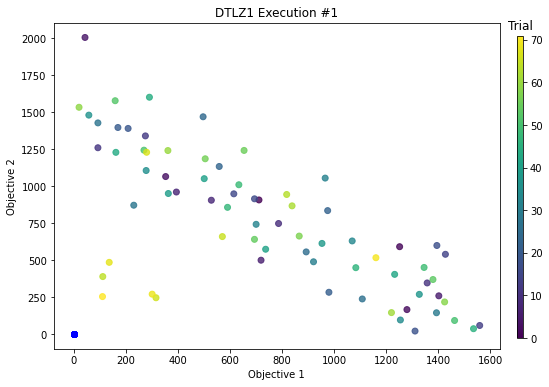

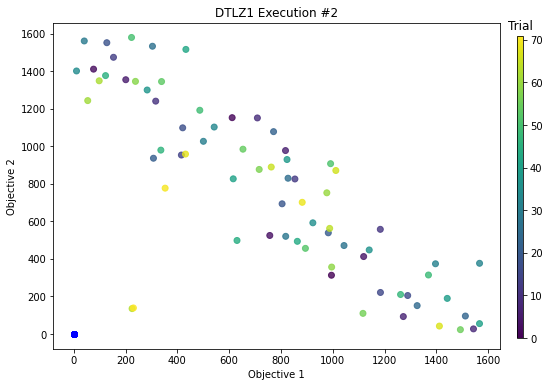

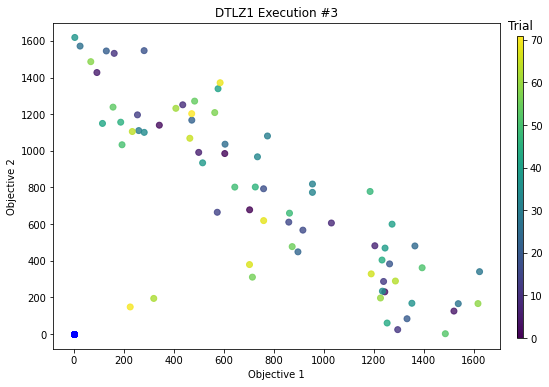

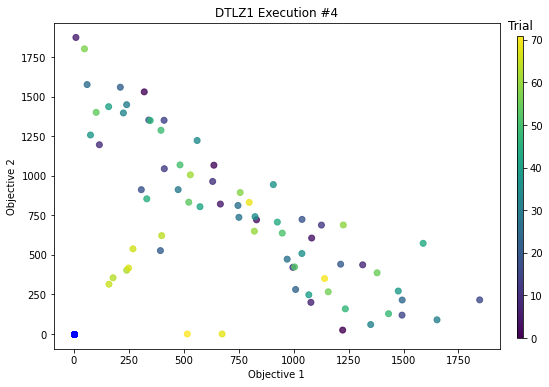

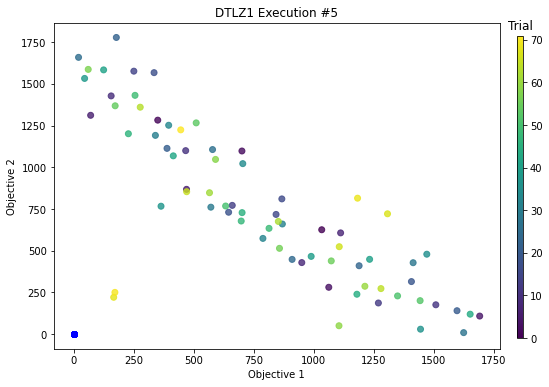

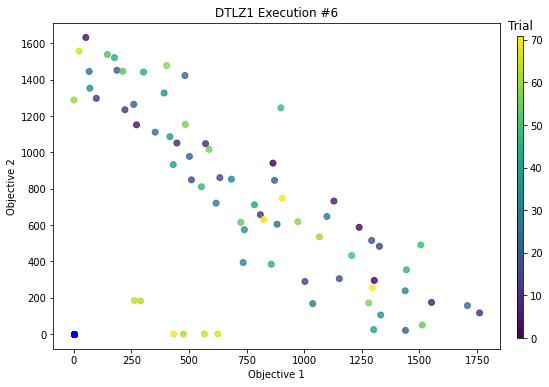

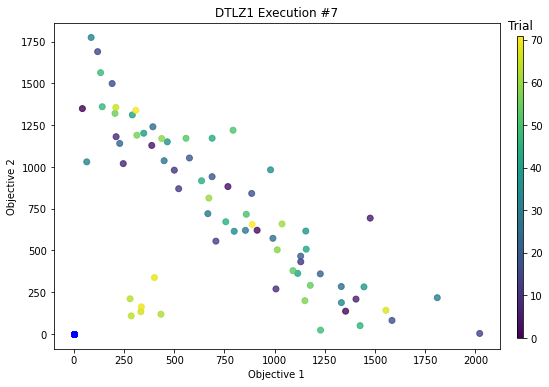

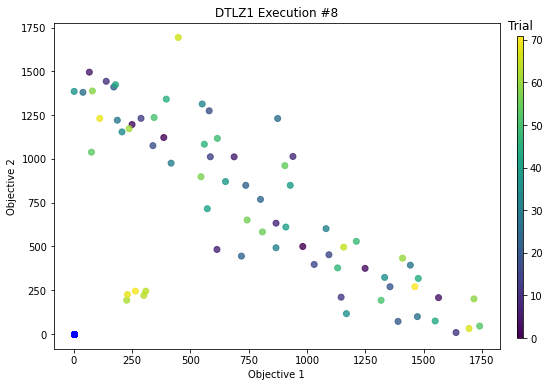

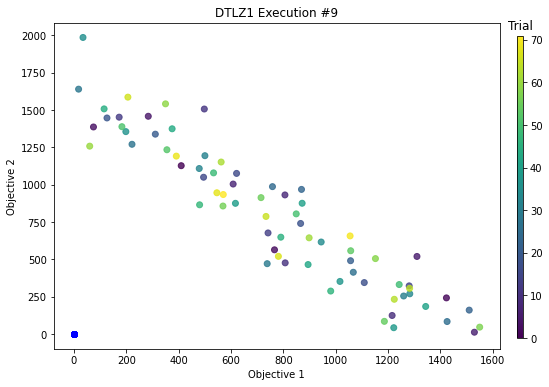

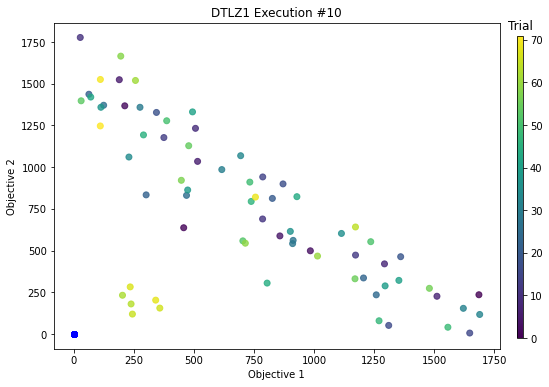

In [8]:
from torch import Tensor
%matplotlib inline

for exec in range(executions):
  fig, axes = plt.subplots(1, 1, figsize=(8,6))

  pareto_front = Tensor.cpu(problem.gen_pareto_front(50))
  axes.scatter(pareto_front[:, 0], pareto_front[:, 1], color='b')


  cm = plt.cm.get_cmap('viridis')
  batch_number = all_df[exec].trial_index.values
  sc = axes.scatter(all_outcomes[exec][:, 0], all_outcomes[exec][:,1], c=batch_number, alpha=0.8)
  axes.set_title(f'DTLZ1 Execution #{exec + 1}')
  axes.set_xlabel("Objective 1")
  axes.set_ylabel("Objective 2")
  norm = plt.Normalize(batch_number.min(), batch_number.max())
  sm =  ScalarMappable(norm=norm, cmap=cm)
  fig.subplots_adjust(right=0.9)
  cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
  cbar = fig.colorbar(sm, cax=cbar_ax)
  cbar.ax.set_title("Trial")

Execution times: [442.43953586 430.92073321 426.28575802 453.36163044 430.13429093
 437.09987211 428.23579955 427.84104323 435.15570998 446.96529937]
Average execution time: 435.8439672708511


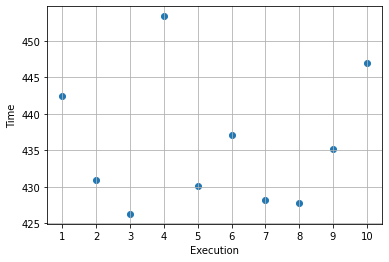

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
plt.xticks(np.arange(1, executions + 1))

axes.scatter(np.arange(1, executions + 1), np.array(execution_times))
axes.grid(True)
axes.set_xlabel("Execution")
axes.set_ylabel("Time")

print("Execution times:", np.array(execution_times))
print("Average execution time:", np.array(execution_times).sum()/len(execution_times))

In [10]:
print(all_df)

[    trial_index arm_name trial_status generation_method            a  \
0             0      0_0      RUNNING             Sobol   710.944368   
1             1      1_0      RUNNING             Sobol  1251.125004   
2             2      2_0      RUNNING             Sobol  1279.222753   
3             3      3_0      RUNNING             Sobol   352.525767   
4             4      4_0      RUNNING             Sobol    42.805891   
..          ...      ...          ...               ...          ...   
67           67     67_0      RUNNING  FullyBayesianMOO   279.414260   
68           68     68_0      RUNNING  FullyBayesianMOO   135.756165   
69           69     69_0      RUNNING  FullyBayesianMOO   300.755005   
70           70     70_0      RUNNING  FullyBayesianMOO  1160.057752   
71           71     71_0      RUNNING  FullyBayesianMOO   109.984885   

              b  is_feasible        x0        x1        x2  ...       x20  \
0    906.703132        False  0.439493  0.073662  0.54304